In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
plt.style.use('ggplot')

# Load Dataset

In [2]:
data = pd.read_csv('employee_retention_data.csv', parse_dates=['join_date', 'quit_date'])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [4]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
employee_id,24702.0,501604.403530,288909.026101,36.0,250133.75,500793.0,753137.25,999969.0
company_id,24702.0,3.426969,2.700011,1.0,1.00,2.0,5.00,12.0
seniority,24702.0,14.127803,8.089520,1.0,7.00,14.0,21.00,99.0
salary,24702.0,138183.345478,76058.184573,17000.0,79000.00,123000.0,187000.00,408000.0


In [5]:
# Null information
data.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [9]:
data.quit_date.notna().sum()

13510

In [11]:
data[data.quit_date.notna()].head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30


# Create Table for `day`, `employee_headcount`, and `company_id`

In [14]:
data.join_date.min(),data.join_date.max()

(Timestamp('2011-01-24 00:00:00'), Timestamp('2015-12-10 00:00:00'))

In [15]:
data.quit_date.min(),data.quit_date.max()

(Timestamp('2011-10-13 00:00:00'), Timestamp('2015-12-09 00:00:00'))

In [12]:
# Define useful information
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(data['company_id'].unique())

day = []
company = []
headcount = []

# Loop through date and company id
for date in unique_date:
    for idx in unique_company:
        total_join = len(data[(data['join_date'] <= date) & (data['company_id'] == idx)])
        total_quit = len(data[(data['quit_date'] <= date) & (data['company_id'] == idx)])
        day.append(date)
        company.append(idx)
        headcount.append(total_join - total_quit)

# Create table for day, employee_headcount, company_id
table = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount}, 
                     columns=['day', 'company_id', 'employee_headcount'])

In [27]:
# data.groupby(['join_date','company_id'])[['quit_date']].count().reset_index()

In [25]:
table.shape

(21420, 3)

In [28]:
table.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


# Employee Churn Analysis

In [29]:
# Separate stay and quit data
quit_data = data[~data['quit_date'].isnull()]
stay_data = data[data['quit_date'].isnull()]

### Feature Engineering

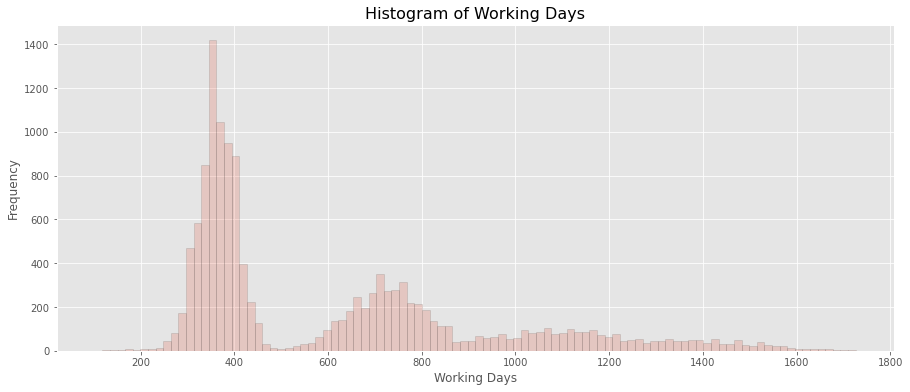

In [30]:
# Total working days
work_days = np.array(list(map(lambda x: x.days, quit_data['quit_date'] - quit_data['join_date'])))

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 6))
sns.distplot(work_days, bins=100, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Working Days', fontsize=16)
ax.set_xlabel('Working Days', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

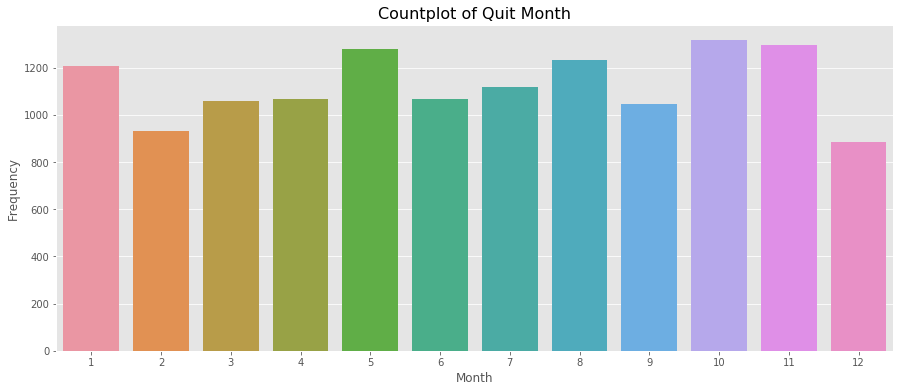

In [18]:
# Week No. for quiting
quit_week = np.array(list(map(lambda x: x.month, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Month', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

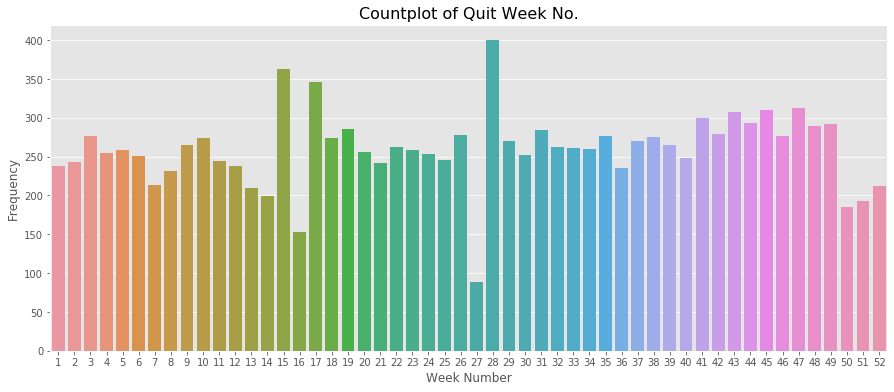

In [19]:
# Week No. for quiting
quit_week = np.array(list(map(lambda x: x.week, quit_data['quit_date'])))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(quit_week, ax=ax)
ax.set_title('Countplot of Quit Week No.', fontsize=16)
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [20]:
# Choose quit data
quit_data['work_days'] = work_days
quit_data['quit_week'] = quit_week

quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_days,quit_week
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,44
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,14
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,23
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,34
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,35


### Decision Tree Model

In [21]:
# Choose the subset data
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31)
subset = data[data['join_date'] < stop_date]

# Binary label for early quit (less than 13 months)
quit = subset['quit_date'].isnull() | (subset['quit_date'] > subset['join_date'] + pd.DateOffset(days=396))
subset['quit'] = 1 - quit.astype(int)

subset.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


In [22]:
# # One-hot encoding
# subset['company_id'] = subset['company_id'].astype(str)
# dummies = pd.get_dummies(subset[['company_id', 'dept']])
# train_x = pd.concat(objs=[subset[['seniority', 'salary']], dummies], axis=1)
# train_y = subset['quit'].values

# train_x.head()

In [23]:
# Label encoder
le = LabelEncoder()
train_x = subset[['company_id', 'seniority', 'salary']]
train_x['dept'] = le.fit_transform(subset['dept'])
train_y = subset['quit'].values

train_x.head()

,company_id,seniority,salary,dept
0,7,28,89000.0,0
1,7,20,183000.0,4
2,4,14,101000.0,4
3,7,20,115000.0,0
4,2,23,276000.0,1


In [24]:
# Build decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=train_x, y=train_y)

In [25]:
# Visualization
features = list(train_x.columns)
targets = ['Not quit', 'Quit']
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True, )  
graph = graphviz.Source(dot_data)
# graph

In [26]:
# Feature importance
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.97439
seniority  | 0.02561
company_id | 0.00000
dept       | 0.00000


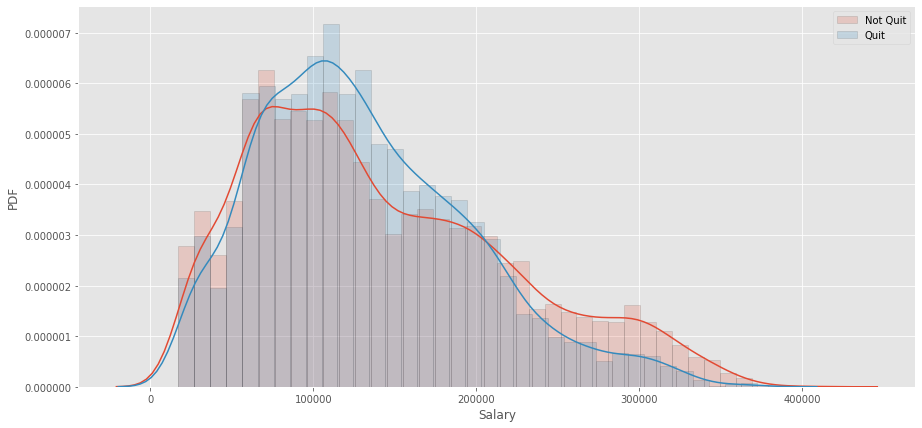

In [27]:
# Visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(subset[subset['quit']==0]['salary'], 
             label='Not Quit', ax=ax, hist_kws=hist_kws)
sns.distplot(subset[subset['quit']==1]['salary'], 
             label='Quit', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('Salary', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

# Other Factors

1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.

2. The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.

3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.